![alt text](https://raw.githubusercontent.com/DarleySoares/codenation_data_science/master/projeto_pratico/images/header.png)

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

palette = ['#F63366', '#FCE92D', '#B0A320', '#2D9AFC', '#206CB0']
sns.set_palette(palette)


# Coleta de dados

In [4]:
# leitura dos dados dos mercados
df_market = pd.read_csv('data/estaticos_market.csv')

# Análise Exploratória

In [5]:
# verificando quantidade de dados vazios por coluna
columns =list(df_market.columns)
null_data = list(df_market.isnull().sum())
df_amount_null_data = pd.DataFrame(data = [columns, null_data])
df_amount_null_data = df_amount_null_data.transpose()
df_amount_null_data.columns = ['Column', 'Amount of null data']

In [6]:
# colunas que estão completas
complete_columns = list(df_amount_null_data.Column.loc[df_amount_null_data['Amount of null data'] == 0])

# colunas que estão totamente incompletas
null_columns = list(df_amount_null_data.Column.loc[df_amount_null_data['Amount of null data'] == df_market.shape[0]])

# colunas que possuem mais de 50% dos dados incompletos
half_null_columns = list(df_amount_null_data.Column.loc[df_amount_null_data['Amount of null data'] >= 0.5 * df_market.shape[0]])

# colunas que possuem menos de 50% dos dados incompletos
less_of_half_null_columns = list(df_amount_null_data.Column.loc[df_amount_null_data['Amount of null data'] < 0.5 * df_market.shape[0]])

In [7]:
print('Colunas com dados totalmente completos: {}'.format(len(complete_columns)))
print('Colunas com dados totalmente incompletos: {}'.format(len(null_columns)))
print('Colunas com mais da metade dos dados incompletos: {}'.format(len(half_null_columns)))
print('Colunas com menos da metade dos dados incompletos: {}'.format(len(less_of_half_null_columns)))

Colunas com dados totalmente completos: 19
Colunas com dados totalmente incompletos: 5
Colunas com mais da metade dos dados incompletos: 131
Colunas com menos da metade dos dados incompletos: 51


# Pré processamento de dados

In [8]:
df = df_market.filter(items = less_of_half_null_columns)

In [9]:
# cria um dicionário com o setor mais frequente de cada ramo
agrup = dict(df.groupby(['de_ramo'])['setor'].agg(pd.Series.mode))
# completa os dados nulos com o termo mais frequente do ramo
df.setor.loc[pd.isnull(df.setor)] = df.de_ramo.map(agrup)

In [10]:
# cria um dicionário com a divisão mais frequente de cada ramo
agrup = df.groupby(['de_ramo'])['nm_divisao'].agg(pd.Series.mode)
# completa os dados nulos com o termo mais frequente do ramo
df.nm_divisao.loc[pd.isnull(df.nm_divisao)] = df.de_ramo.map(agrup)

In [11]:
# remove a data na qual uma situação foi registrado na Receita Federal
df.drop(['dt_situacao'], axis = 1, inplace = True)

In [12]:
# cria um dicionário com o segmento mais frequente de cada ramo
agrup = df.groupby(['de_ramo'])['nm_segmento'].agg(pd.Series.mode)
# completa os dados nulos com o termo mais frequente do ramo
df.nm_segmento.loc[pd.isnull(df.nm_segmento)] = df.de_ramo.map(agrup)

In [13]:
# completa os dados nulos com o valor False, que representa não possuir estação de abastecimento próprio
df.fl_spa.fillna(False, inplace = True)

In [14]:
# completa os dados nulos com o valor False, que representa não possui certificação ANTT para transportação
df.fl_antt.fillna(False, inplace = True)

In [15]:
# completa os dados nulos com o valor zero, que representa que a empresa não possui veículos que pertencem ao grupo pesados ou leves
df.vl_total_veiculos_pesados_grupo.fillna(0, inplace = True)
df.vl_total_veiculos_leves_grupo.fillna(0, inplace = True)

# completa os dados nulos com o valor da soma do total de veículos dos grupos leves e pesados
aux = df.vl_total_veiculos_pesados_grupo + df.vl_total_veiculos_leves_grupo
df.fl_veiculo = list(map(lambda x: True if x > 0 else False, aux))

In [16]:
# exclui as colunas que não são interessantes para a análise
df.drop(columns = ['fl_optante_simples','fl_optante_simei','sg_uf_matriz','de_saude_tributaria','de_saude_rescencia','nu_meses_rescencia','idade_media_socios','idade_maxima_socios','idade_minima_socios','de_faixa_faturamento_estimado_grupo','vl_faturamento_estimado_grupo_aux','fl_passivel_iss','qt_socios_st_regular','fl_simples_irregular','empsetorcensitariofaixarendapopulacao'], axis = 1, inplace = True)

In [17]:
# completa os dados nulos com o valor zero, que representa que a empresa não possui sócios do tipo pessoa jurídico ou pessoa física.
df.qt_socios_pj.fillna(0, inplace = True)
df.qt_socios_pf.fillna(0, inplace = True)
df.qt_socios.fillna(df.qt_socios_pj+df.qt_socios_pf, inplace = True)

In [18]:
# cria um dicionário com a meso região mais frequente de cada estado
agrup = df.groupby(['sg_uf'])['nm_meso_regiao'].agg(pd.Series.mode)
# completa os dados nulos com o termo mais frequento do estado
df.nm_meso_regiao.loc[pd.isnull(df.nm_meso_regiao)] = df.sg_uf.map(agrup)

# cria um dicionário com a micro região mais frequente de cada estado
agrup = df.groupby(['sg_uf'])['nm_micro_regiao'].agg(pd.Series.mode)
# completa os dados nulos com o termo mais frequente do micro região
df.nm_micro_regiao.loc[pd.isnull(df.nm_micro_regiao)] = df.sg_uf.map(agrup)

In [19]:
# completa os dados nulos com a mediana do valor de faturamento estimado
df.vl_faturamento_estimado_aux.fillna(df.vl_faturamento_estimado_aux.median(), inplace = True)
df.de_faixa_faturamento_estimado.fillna(df.de_faixa_faturamento_estimado.mode().values[0], inplace = True)

In [20]:
# cria um dicionário com o tipo de atividade mais frequente de cada faixa de faturamento estimado
agrup = df.groupby(['de_faixa_faturamento_estimado'])['de_nivel_atividade'].agg(pd.Series.mode)
# completa os dados nulos com o termo mais frequento do por faixa de faturamento
df.de_nivel_atividade.loc[pd.isnull(df.de_nivel_atividade)] = df.de_faixa_faturamento_estimado.map(agrup)

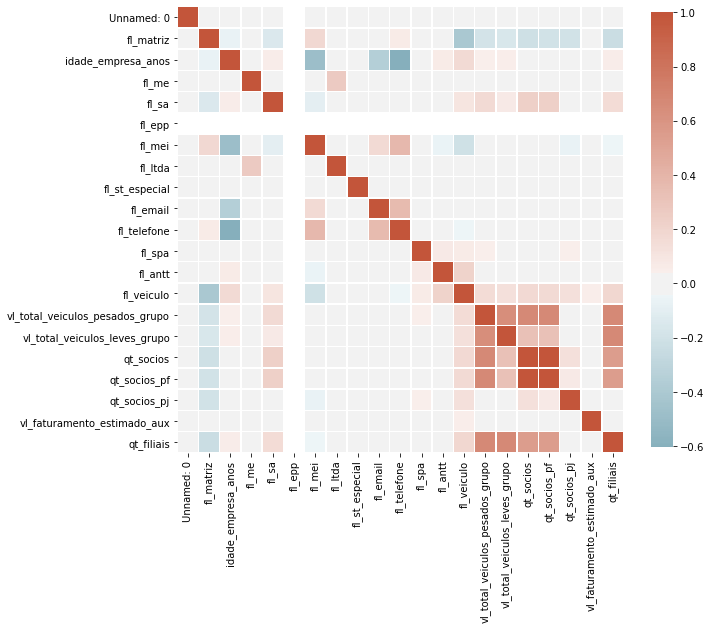

In [21]:
df.corr()
corr = df.corr()
f, ax = plt.subplots(figsize= (10, 10))
cmap = sns.diverging_palette(220,20, as_cmap= True)
sns.heatmap(corr, cmap = cmap, vmax = 1, center = 0, square = True, linewidths= .5, cbar_kws= {'shrink': .8})

In [64]:
# cria um dataset com algumas colunas selecionadas para serem testadas o processo de clusterização
df_cluster = df.filter(items = ['id','de_natureza_juridica','sg_uf','de_ramo','setor','idade_empresa_anos','nm_segmento','de_nivel_atividade','nm_meso_regiao','nm_micro_regiao','qt_socios','vl_faturamento_estimado_aux'])

In [65]:
df_cluster.head()

,id,de_natureza_juridica,sg_uf,de_ramo,setor,idade_empresa_anos,nm_segmento,de_nivel_atividade,nm_meso_regiao,nm_micro_regiao,qt_socios,vl_faturamento_estimado_aux
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,SOCIEDADE EMPRESARIA LIMITADA,RN,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,CONSTRUCAO,ALTA,LESTE POTIGUAR,NATAL,2.0,3132172.8
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,EMPRESARIO INDIVIDUAL,PI,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,ALOJAMENTO E ALIMENTACAO,BAIXA,CENTRO NORTE PIAUIENSE,TERESINA,1.0,210000.0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,EMPRESARIO INDIVIDUAL,AM,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,TRANSPORTE ARMAZENAGEM E CORREIO,MEDIA,CENTRO AMAZONENSE,MANAUS,1.0,50000.0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,EMPRESARIO INDIVIDUAL,AM,SERVICOS DIVERSOS,SERVIÇO,6.512329,OUTRAS ATIVIDADES DE SERVICOS,MEDIA,CENTRO AMAZONENSE,MANAUS,1.0,210000.0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,EMPRESARIO INDIVIDUAL,RN,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,ALTA,LESTE POTIGUAR,NATAL,1.0,210000.0


Os componentes principais são combinações lineares das variáveis originais, transformando-as em um novo sistema de coordenadas ortogonais. 